In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resized-2015-2019-blindness-detection-images', 'pretrained-pytorch-models', 'aptos-pytorch', 'aptos2019-blindness-detection', 'fastai-pretrained-models', 'resnet152']


In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CosineSimilarity
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models
from pathlib import Path
import PIL.Image
import random
import math
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
import os
import glob
import cv2
import numpy as np
import PIL
from sklearn.metrics import cohen_kappa_score

# Copy pretrained models

In [3]:
# copy pretrained weights for resnet50 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp /kaggle/input/fastai-pretrained-models/* /tmp/.cache/torch/checkpoints/
!cp /kaggle/input/pretrained-pytorch-models/* /tmp/.cache/torch/checkpoints/
!cp /kaggle/input/resnet152/* /tmp/.cache/torch/checkpoints/
!mv /tmp/.cache/torch/checkpoints/resnet152.pth /tmp/.cache/torch/checkpoints/resnet152-b121ed2d.pth
!ls /tmp/.cache/torch/checkpoints/

densenet121-a639ec97.pth	  resnet152-b121ed2d.pth
densenet161-17b70270.pth	  resnet18-5c106cde.pth
densenet169-b2777c0a.pth	  resnet50-19c8e357.pth
densenet201-c1103571.pth	  squeezenet1_0-a815701f.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_1-f364aa15.pth
resnet101-5d3b4d8f.pth		  vgg16_bn-6c64b313.pth


# Set fixed seed

In [4]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Data from 2015

In [5]:
path = Path('../input/resized-2015-2019-blindness-detection-images/')

In [6]:
img_paths = []
img_diags = []
img_ids = []

In [7]:
df = pd.read_csv(path/'labels/testLabels15.csv')
df['path'] = df.image.apply(lambda p: path/'resized test 15'/(p + '.jpg'))
img_paths.extend(df['path'].tolist())
img_diags.extend(df['level'].tolist())
img_ids.extend(df['image'].tolist())

In [8]:
df = pd.read_csv(path/'labels/trainLabels15.csv')
df['path'] = df.image.apply(lambda p: path/'resized train 15'/(p + '.jpg'))
img_paths.extend(df['path'].tolist())
img_diags.extend(df['level'].tolist())
img_ids.extend(df['image'].tolist())

In [9]:
tr_df = pd.DataFrame({'id_code':img_ids, 'diagnosis': img_diags, 'path':img_paths})

In [10]:
tr_df, tr_va_df = train_test_split(tr_df, test_size=0.05, random_state=42, stratify=tr_df.diagnosis)

# Data from 2019

In [11]:
# path = Path('../input/aptos2019-blindness-detection')
path = Path('../input/resized-2015-2019-blindness-detection-images/')

In [12]:
df = pd.read_csv(path/'labels/trainLabels19.csv')

In [13]:
img_paths = []
img_diags = []
img_ids = []

In [14]:
df['path'] = df.id_code.apply(lambda p: path/'resized train 19'/(p + '.jpg'))
img_paths.extend(df['path'].tolist())
img_diags.extend(df['diagnosis'].tolist())
img_ids.extend(df['id_code'].tolist())

In [15]:
te_va_df = pd.DataFrame({'id_code':img_ids, 'diagnosis': img_diags, 'path':img_paths})
tr_df = pd.DataFrame({'id_code':img_ids, 'diagnosis': img_diags, 'path':img_paths})

In [16]:
tr_df, tr_va_df = train_test_split(tr_df, test_size=0.20, random_state=42, stratify=tr_df.diagnosis)

# Circle crop

In [17]:
class CircleCrop:
    def __init__(self, radius):
        self.radius = radius
        circle_img = np.zeros((2 * radius, 2 * radius), np.uint8)
        cv2.circle(circle_img, (radius, radius), int(radius), 1, thickness=-1)
        self.mask = torch.tensor(circle_img, dtype=torch.float32)
        
    def __call__(self, img):
        return torch.mul(img, self.mask)
    
    def __repr__(self):
        return self.__class__.__name__ + '(radius={0})'.format(self.radius)

# APTOS Dataset

In [18]:
class APTOSDataset(Dataset):
    def __init__(self, df, labels=None, augmentation=False, img_size=480):
        self.len = len(df)
        self.labels = labels
        self.images = df.path.tolist()
        self.trfms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.RandomApply((
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomAffine(degrees=180, scale=(1.0, 1.5), resample=PIL.Image.BICUBIC),
                ), p = 1 if augmentation else 0  
            ),
            transforms.ColorJitter(
                saturation=(1.0, 1.0),
                brightness=(1.0, 1.5), 
                contrast=(1.5, 2.5),
            ),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]),
            CircleCrop(img_size // 2),
            ])
        
    def __getitem__(self, index):
        if self.labels is not None:
            label = self.labels[index]
        else:
            label = 0
        path = self.images[index]
        img = PIL.Image.open(path)
        img = self.trfms(img)
        return img, label
    
    def __len__(self):
        return self.len

# Create datasets

In [19]:
path = Path('../input')
img_size = 256

In [20]:
tr_ds = APTOSDataset(tr_df, tr_df['diagnosis'].values, augmentation=True, img_size=img_size)

In [21]:
tr_va_ds = APTOSDataset(tr_va_df, tr_va_df['diagnosis'].values, augmentation=False, img_size=img_size)

In [22]:
te_va_ds = APTOSDataset(te_va_df, te_va_df['diagnosis'].values, augmentation=False, img_size=img_size)

In [23]:
len(tr_ds), len(tr_va_ds), len(te_va_ds)

(2929, 733, 3662)

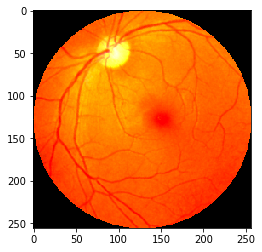

In [24]:
img, label = tr_ds[random.randint(0, len(tr_ds) - 1)]
plt.imshow(transforms.ToPILImage()(img))

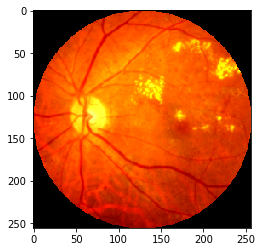

In [25]:
img, label = tr_va_ds[random.randint(0, len(tr_va_ds) - 1)]
plt.imshow(transforms.ToPILImage()(img))

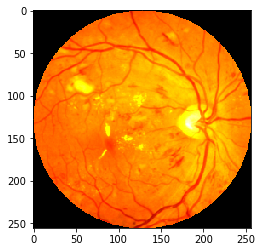

In [26]:
img, label = te_va_ds[random.randint(0, len(te_va_ds) - 1)]
plt.imshow(transforms.ToPILImage()(img))

# Dataloaders

In [27]:
bs = 48
nw = 4

In [28]:
# class_weights = torch.tensor([0.05,0.20,0.15,0.30,0.30])
# tr_labels = tr_ds.labels
# sample_weights = class_weights[tr_labels]
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(tr_ds))

In [29]:
tr_dl = DataLoader(tr_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True, shuffle=True)
# tr_dl = DataLoader(tr_ds, batch_size=bs, num_workers=nw, drop_last=False, pin_memory=True, sampler=sampler)

In [30]:
tr_va_dl = DataLoader(tr_va_ds, batch_size=bs, num_workers=nw, drop_last=False, pin_memory=True, shuffle=False)

In [31]:
te_va_dl = DataLoader(te_va_ds, batch_size=bs, num_workers=nw, drop_last=False, pin_memory=True, shuffle=False)

# Model

In [32]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [33]:
class Bias(nn.Module):
    def __init__(self, num_out):
        super(Bias, self).__init__()
        self.bias = nn.Parameter(torch.zeros(num_out).float())
        
    def forward(self, x):
        return x + self.bias

In [34]:
num_classes = 5

In [35]:
# # Linear classifier
# model = nn.Sequential(
# #     nn.AvgPool2d(kernel_size=2),
#     Flatten(),
#     nn.Linear(in_features=480 * 480 * 3,
#              out_features=num_classes)
# ).cuda()

In [36]:
model = models.densenet201(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.BatchNorm1d(1920),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1920, out_features=512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=num_classes),
    nn.Linear(in_features=num_classes, out_features=1, bias=False),
    Bias(num_classes - 1)
#     nn.Hardtanh(min_val=0.0, max_val=4.0)
)
# model.fc = nn.Linear(in_features=2048, out_features=num_classes)
# model.classifier.requires_grad = True
model = model.cuda()

In [37]:
# for name, param in model.named_parameters():
# # for layer in model.features:
#     if 'norm' in name:
# #     if isinstance(layer, nn.BatchNorm2d):
# #         for param in layer.parameters():
#         param.requires_grad = True
#     else:
# #         for param in layer.parameters():
#         param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = False
    
# for layer in model.modules():
#     if isinstance(layer, nn.BatchNorm1d):
#         for param in layer.parameters():
#             param.requires_grad = False
    
# for param in model.features.transition1.parameters():
#     param.requires_grad = True
    
# for param in model.features.transition2.parameters():
#     param.requires_grad = True
    
# for param in model.features.transition3.parameters():
#     param.requires_grad = True

In [38]:
for name, param in model.named_parameters():
    param.requires_grad = True

In [39]:
# model.classifier[8].bias.requires_grad = True

In [40]:
for name, param in model.named_parameters():
    print('{:<48}\t{}\t{}'.format(name, param.requires_grad, torch.numel(param)))

features.conv0.weight                           	True	9408
features.norm0.weight                           	True	64
features.norm0.bias                             	True	64
features.denseblock1.denselayer1.norm1.weight   	True	64
features.denseblock1.denselayer1.norm1.bias     	True	64
features.denseblock1.denselayer1.conv1.weight   	True	8192
features.denseblock1.denselayer1.norm2.weight   	True	128
features.denseblock1.denselayer1.norm2.bias     	True	128
features.denseblock1.denselayer1.conv2.weight   	True	36864
features.denseblock1.denselayer2.norm1.weight   	True	96
features.denseblock1.denselayer2.norm1.bias     	True	96
features.denseblock1.denselayer2.conv1.weight   	True	12288
features.denseblock1.denselayer2.norm2.weight   	True	128
features.denseblock1.denselayer2.norm2.bias     	True	128
features.denseblock1.denselayer2.conv2.weight   	True	36864
features.denseblock1.denselayer3.norm1.weight   	True	128
features.denseblock1.denselayer3.norm1.bias     	True	128
features.den

In [41]:
optimizer = Adam(model.parameters(), lr=3e-5)

In [42]:
checkpoint = torch.load('../input/aptos-pytorch/checkpoint.tar')
model.load_state_dict(checkpoint['model'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer'])

In [43]:
# for p in model.layer4.parameters():
#     p.requires_grad = True
# for p in model.layer3.parameters():
#     p.requires_grad = True

In [44]:
optimizer.param_groups[0]['lr'] = 3e-6

In [45]:
# optimizer.param_groups[0]['betas'] = (0.999, 0.999)

# Loss functions

In [46]:
class CumulativeProbabilityOrdinalLoss(nn.Module):
    def __init__(self):
        super(CumulativeProbabilityOrdinalLoss, self).__init__()
        
    def forward(self, output, label):
        prob = F.softmax(output, dim=1)
        cdf = torch.cumsum(prob, dim=1)
        one_hot = torch.zeros_like(prob)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        label_cdf = torch.cumsum(one_hot, dim=1)
        return F.mse_loss(cdf, label_cdf)

In [47]:
class CoralLoss(nn.Module):
    def __init__(self):
        super(CoralLoss, self).__init__()
        self.exceed_rank = torch.tensor([[0, 0, 0, 0],
                            [1, 0, 0, 0],
                            [1, 1, 0, 0],
                            [1, 1, 1, 0],
                            [1, 1, 1, 1],
                           ]).float().cuda()
        
    def forward(self, output, label):
        return F.binary_cross_entropy_with_logits(output, self.exceed_rank[label])

In [48]:
class SquareWeightedMSEOnProbabilityLoss(nn.Module):
    def __init__(self):
        super(SquareWeightedMSEOnProbabilityLoss, self).__init__()
        self.weights = torch.tensor([
            [0, 1, 4, 9, 16], 
            [1, 0, 1, 4, 9], 
            [4, 1, 0, 1, 4], 
            [9, 4, 1, 0, 1], 
            [16, 9, 4, 1, 0]], dtype=torch.float32).cuda()
        
    def forward(self, output, label):
        prob = F.softmax(output, dim=1)
        return torch.mean(torch.pow(torch.mul(self.weights[label], prob), 2))

In [49]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [50]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean', weight=None):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none', weight=self.weight)(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [51]:
# criterion = nn.CrossEntropyLoss()
# criterion = LabelSmoothingLoss(0.2)
# ce_loss_weights = torch.tensor([1.0, 15.0, 5.0, 10.0, 10.0])
# ce_loss_weights /= ce_loss_weights.sum()
# criterion = FocalLoss()
# criterion = nn.MSELoss()
criterion = CoralLoss()
# criterion = CumulativeProbabilityOrdinalLoss()
# criterion = SquareWeightedMSEOnProbabilityLoss()

# Train

In [52]:
def reg_out_to_class(out):
    return torch.round(out).int()

In [53]:
def coral_out_to_class(out):
    out = torch.sigmoid(out)
    out = out > 0.5
    return torch.sum(out, dim=1)

In [54]:
def train_one_epoch(model, optimizer, criterion, dl, batch_count=None):
    if batch_count is None:
        batch_count = len(dl)
    metrics = []
#     count = 0
    for inputs, targets in tqdm(dl):
        model.train()
        inputs, targets = inputs.cuda(), targets.cuda() #targets.reshape((-1,1)).float().cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            model.eval()
#             preds = torch.argmax(outputs, dim=1)
#             preds = reg_out_to_class(outputs)
            preds = coral_out_to_class(outputs)
#             print(preds.dtype)
#             targets = targets.int()
            accu = (preds == targets).sum().item() / float(inputs.shape[0])
            metrics.append((loss.item(), accu))
#         count += 1
#         if count >= batch_count:
#             break
    
    return metrics

In [55]:
def validate_model_on(model, dl, criterion):
    with torch.no_grad():
        model.eval()
        conf_matrix = [[0 for i in range(num_classes)] for j in range(num_classes)]
        loss = 0.0
        accu = 0.0
        y1, y2 = [], []
        for inputs, targets in tqdm(dl):
            inputs, targets = inputs.cuda(), targets.cuda() #targets.reshape((-1,1)).float().cuda()
            outputs = model(inputs)
#             preds = torch.argmax(outputs, dim=1)
#             preds = reg_out_to_class(outputs)
            preds = coral_out_to_class(outputs)
            y1.extend(targets.tolist())
            y2.extend(preds.tolist())
            loss += criterion(outputs, targets).item()
#             targets = targets.int()
#             print(preds, targets)
            accu += (preds == targets).sum().item() / float(inputs.shape[0])
            for i in range(len(preds)):
                conf_matrix[targets[i]][preds[i]] += 1
        loss /= len(dl)
        accu /= len(dl)
        kappa = cohen_kappa_score(y1, y2, weights='quadratic')
    return loss, accu, kappa, conf_matrix

In [56]:
num_epochs = 40

In [57]:
tr_metrics = []
tr_va_metrics = []
te_va_metrics = []

In [58]:
for epoch in tqdm(range(num_epochs)):                        
    print('Epoch: {}'.format(epoch))
    metrics = train_one_epoch(model, optimizer, criterion, tr_dl)
    mean = lambda l: sum(l) / len(l)
    tr_loss = mean(list(map(lambda m:m[0], metrics)))
    tr_accu = mean(list(map(lambda m:m[1], metrics)))
    tr_metrics.extend(metrics)
    print('Train Loss: {} Acc: {}'.format(tr_loss, tr_accu))

    tr_va_loss, tr_va_accu, tr_va_kappa, tr_va_conf_matrix = validate_model_on(model, tr_va_dl, criterion)
    print('Train Val Loss: {} Acc: {} Kappa: {}'.format(tr_va_loss, tr_va_accu, tr_va_kappa))
    for row in tr_va_conf_matrix:
        print(row)
    tr_va_metrics.append((tr_va_loss, tr_va_accu, tr_va_kappa))
    
#     te_va_loss, te_va_accu, te_va_kappa, te_va_conf_matrix = validate_model_on(model, te_va_dl, criterion)
#     print('Test Val Loss: {} Acc: {} Kappa: {}'.format(te_va_loss, te_va_accu, te_va_kappa))
#     for row in te_va_conf_matrix:
#         print(row)
#     te_va_metrics.append((te_va_loss, te_va_accu, te_va_kappa))

Epoch: 0


Train Loss: 0.2069790287584555 Acc: 0.746926229508197


Train Val Loss: 0.20192385092377663 Acc: 0.7698317307692306 Kappa: 0.834046755146373
[359, 1, 1, 0, 0]
[19, 9, 45, 1, 0]
[4, 2, 188, 6, 0]
[0, 0, 28, 10, 1]
[1, 0, 48, 9, 1]
Epoch: 1


Train Loss: 0.21225371565975126 Acc: 0.7424863387978143


Train Val Loss: 0.20366733241826296 Acc: 0.767227564102564 Kappa: 0.8361345982898747
[359, 1, 1, 0, 0]
[21, 11, 42, 0, 0]
[3, 9, 183, 5, 0]
[0, 0, 27, 11, 1]
[1, 1, 45, 11, 1]
Epoch: 2


Train Loss: 0.21781161085504 Acc: 0.7390710382513661


Train Val Loss: 0.2028131140395999 Acc: 0.7585136217948717 Kappa: 0.8383872390201654
[359, 2, 0, 0, 0]
[22, 8, 44, 0, 0]
[4, 8, 183, 5, 0]
[0, 0, 28, 10, 1]
[1, 0, 45, 12, 1]
Epoch: 3


Train Loss: 0.2149811562944631 Acc: 0.7455601092896175


Train Val Loss: 0.20386215718463063 Acc: 0.7646233974358975 Kappa: 0.8271731296335494
[360, 1, 0, 0, 0]
[21, 10, 43, 0, 0]
[3, 7, 184, 6, 0]
[0, 0, 30, 9, 0]
[1, 1, 50, 7, 0]
Epoch: 4


Train Loss: 0.21258976347133762 Acc: 0.7459016393442625


Train Val Loss: 0.20117242634296417 Acc: 0.7646233974358976 Kappa: 0.8401974282476378
[359, 2, 0, 0, 0]
[19, 9, 46, 0, 0]
[3, 6, 182, 9, 0]
[0, 0, 25, 13, 1]
[1, 2, 41, 15, 0]
Epoch: 5


Train Loss: 0.21238065791911767 Acc: 0.7465846994535518


Train Val Loss: 0.20449335128068924 Acc: 0.7594150641025642 Kappa: 0.8257225939248548
[359, 2, 0, 0, 0]
[23, 7, 44, 0, 0]
[4, 6, 184, 6, 0]
[0, 0, 30, 9, 0]
[1, 1, 49, 8, 0]
Epoch: 6


Train Loss: 0.2138998579294955 Acc: 0.7435109289617488


Train Val Loss: 0.20224145241081715 Acc: 0.7737379807692306 Kappa: 0.8341086830789348
[359, 1, 1, 0, 0]
[16, 12, 46, 0, 0]
[4, 4, 186, 6, 0]
[0, 0, 25, 13, 1]
[1, 1, 47, 10, 0]
Epoch: 7


Train Loss: 0.2111741074773132 Acc: 0.7400956284153006


Train Val Loss: 0.20347299706190825 Acc: 0.7698317307692307 Kappa: 0.837678319007699
[358, 2, 1, 0, 0]
[20, 11, 43, 0, 0]
[4, 5, 186, 5, 0]
[0, 0, 28, 11, 0]
[1, 0, 46, 11, 1]
Epoch: 8


Train Loss: 0.21528835032807023 Acc: 0.7445355191256833


Train Val Loss: 0.20376768801361322 Acc: 0.7685296474358972 Kappa: 0.8412973136675663
[358, 3, 0, 0, 0]
[21, 11, 42, 0, 0]
[3, 6, 186, 5, 0]
[0, 0, 28, 11, 0]
[1, 0, 45, 13, 0]
Epoch: 9


Train Loss: 0.21541087744665927 Acc: 0.7472677595628415


Train Val Loss: 0.20921511948108673 Acc: 0.7672275641025641 Kappa: 0.8326599523235627
[358, 3, 0, 0, 0]
[23, 8, 43, 0, 0]
[4, 7, 186, 3, 0]
[0, 0, 25, 13, 1]
[1, 1, 47, 10, 0]
Epoch: 10


Train Loss: 0.21083781929289708 Acc: 0.7329234972677596


Train Val Loss: 0.2052236944437027 Acc: 0.7607171474358975 Kappa: 0.8314810409692608
[359, 2, 0, 0, 0]
[22, 6, 46, 0, 0]
[4, 6, 185, 5, 0]
[0, 0, 30, 9, 0]
[1, 1, 46, 10, 1]
Epoch: 11


Train Loss: 0.21589194164901485 Acc: 0.7394125683060111


Train Val Loss: 0.19804192800074816 Acc: 0.771133814102564 Kappa: 0.8423161256071254
[357, 2, 2, 0, 0]
[16, 13, 45, 0, 0]
[3, 2, 187, 8, 0]
[0, 0, 28, 10, 1]
[1, 0, 44, 13, 1]
Epoch: 12


Train Loss: 0.21350535872529763 Acc: 0.744535519125683


Train Val Loss: 0.20514791272580624 Acc: 0.7611177884615384 Kappa: 0.8290442417199225
[359, 2, 0, 0, 0]
[23, 8, 43, 0, 0]
[3, 6, 186, 5, 0]
[0, 0, 29, 10, 0]
[1, 1, 49, 8, 0]
Epoch: 13


Train Loss: 0.21502635176064538 Acc: 0.7421448087431695


Train Val Loss: 0.19908661022782326 Acc: 0.7659254807692307 Kappa: 0.839621924367687
[357, 3, 1, 0, 0]
[21, 11, 42, 0, 0]
[3, 5, 186, 6, 0]
[0, 0, 29, 9, 1]
[1, 0, 45, 12, 1]
Epoch: 14


Train Loss: 0.21374887325724617 Acc: 0.7431693989071037


Train Val Loss: 0.20047020260244608 Acc: 0.7620192307692308 Kappa: 0.8338317994893374
[359, 1, 1, 0, 0]
[22, 8, 44, 0, 0]
[3, 5, 186, 6, 0]
[0, 0, 30, 8, 1]
[1, 1, 45, 12, 0]
Epoch: 15


Train Loss: 0.22248004938735336 Acc: 0.7336065573770492


Train Val Loss: 0.20042544789612293 Acc: 0.7702323717948717 Kappa: 0.8444175794042114
[361, 0, 0, 0, 0]
[20, 11, 43, 0, 0]
[3, 5, 187, 5, 0]
[0, 0, 29, 9, 1]
[1, 0, 45, 11, 2]
Epoch: 16


Train Loss: 0.2117136453018814 Acc: 0.7489754098360658


Train Val Loss: 0.20232492685317993 Acc: 0.7672275641025639 Kappa: 0.8371190459190176
[358, 3, 0, 0, 0]
[19, 13, 42, 0, 0]
[4, 8, 184, 4, 0]
[0, 0, 30, 9, 0]
[1, 0, 46, 11, 1]
Epoch: 17


Train Loss: 0.2134756174732427 Acc: 0.7322404371584698


Train Val Loss: 0.19827476982027292 Acc: 0.7737379807692306 Kappa: 0.8421053329259345
[358, 3, 0, 0, 0]
[18, 11, 45, 0, 0]
[3, 1, 190, 6, 0]
[0, 0, 29, 10, 0]
[1, 0, 46, 11, 1]
Epoch: 18


Train Loss: 0.2171341065989166 Acc: 0.7397540983606559


Train Val Loss: 0.20610963460057974 Acc: 0.7650240384615384 Kappa: 0.8360508743320637
[360, 1, 0, 0, 0]
[27, 9, 38, 0, 0]
[3, 8, 185, 4, 0]
[0, 0, 28, 11, 0]
[1, 1, 46, 10, 1]
Epoch: 19


Train Loss: 0.21700443254142512 Acc: 0.7404371584699452


Train Val Loss: 0.2013043463230133 Acc: 0.7646233974358972 Kappa: 0.8390794260828396
[357, 4, 0, 0, 0]
[21, 10, 43, 0, 0]
[3, 5, 186, 6, 0]
[0, 0, 30, 8, 1]
[1, 0, 46, 10, 2]
Epoch: 20


Train Loss: 0.21471582035549353 Acc: 0.7339480874316939


Train Val Loss: 0.20620827563107014 Acc: 0.7572115384615384 Kappa: 0.8273345390809967
[359, 2, 0, 0, 0]
[24, 6, 44, 0, 0]
[3, 7, 184, 6, 0]
[0, 0, 28, 11, 0]
[1, 2, 47, 9, 0]
Epoch: 21


Train Loss: 0.21335310623294018 Acc: 0.7332650273224042


Train Val Loss: 0.20055738929659128 Acc: 0.7737379807692307 Kappa: 0.8413273922101203
[358, 3, 0, 0, 0]
[18, 12, 44, 0, 0]
[3, 2, 190, 5, 0]
[0, 0, 29, 9, 1]
[1, 1, 44, 12, 1]
Epoch: 22


Train Loss: 0.20851572737342022 Acc: 0.7452185792349727


Train Val Loss: 0.20212476421147585 Acc: 0.7659254807692307 Kappa: 0.8344405176308027
[359, 1, 1, 0, 0]
[20, 9, 45, 0, 0]
[3, 5, 187, 5, 0]
[0, 0, 30, 8, 1]
[1, 0, 48, 9, 1]
Epoch: 23


Train Loss: 0.2145004072150246 Acc: 0.73155737704918


Train Val Loss: 0.20190960355103016 Acc: 0.7607171474358974 Kappa: 0.8326969760937253
[358, 1, 2, 0, 0]
[22, 6, 46, 0, 0]
[3, 3, 187, 7, 0]
[0, 0, 30, 8, 1]
[1, 1, 45, 11, 1]
Epoch: 24


Train Loss: 0.20939777718215694 Acc: 0.7476092896174861


Train Val Loss: 0.2073170393705368 Acc: 0.7594150641025641 Kappa: 0.8259390688076309
[359, 2, 0, 0, 0]
[25, 7, 42, 0, 0]
[3, 9, 185, 3, 0]
[0, 0, 30, 8, 1]
[1, 2, 47, 9, 0]
Epoch: 25


Train Loss: 0.20338209608539207 Acc: 0.7431693989071035


Train Val Loss: 0.20155373215675354 Acc: 0.7620192307692306 Kappa: 0.8292544227040484
[359, 2, 0, 0, 0]
[23, 9, 42, 0, 0]
[3, 8, 184, 5, 0]
[0, 0, 30, 8, 1]
[1, 0, 51, 6, 1]
Epoch: 26


Train Loss: 0.21353131752522264 Acc: 0.7349726775956283


Train Val Loss: 0.20173051487654448 Acc: 0.763321314102564 Kappa: 0.8360979572611237
[358, 3, 0, 0, 0]
[26, 8, 40, 0, 0]
[3, 7, 184, 6, 0]
[0, 0, 28, 11, 0]
[1, 1, 45, 11, 1]
Epoch: 27


Train Loss: 0.21182594558254617 Acc: 0.7421448087431693


Train Val Loss: 0.1986005692742765 Acc: 0.7689302884615383 Kappa: 0.8427109031692412
[360, 1, 0, 0, 0]
[19, 10, 45, 0, 0]
[3, 7, 185, 5, 0]
[0, 0, 26, 12, 1]
[1, 0, 46, 10, 2]
Epoch: 28


Train Loss: 0.2182232212336337 Acc: 0.7400956284153006


Train Val Loss: 0.20026174746453762 Acc: 0.7685296474358974 Kappa: 0.8429466239375123
[359, 2, 0, 0, 0]
[20, 10, 44, 0, 0]
[3, 4, 187, 6, 0]
[0, 0, 28, 10, 1]
[1, 1, 42, 15, 0]
Epoch: 29


Train Loss: 0.21406890378623714 Acc: 0.7404371584699452


Train Val Loss: 0.2058956390246749 Acc: 0.7607171474358974 Kappa: 0.8279868451050567
[360, 1, 0, 0, 0]
[26, 8, 40, 0, 0]
[3, 10, 183, 4, 0]
[0, 0, 30, 9, 0]
[1, 2, 46, 10, 0]
Epoch: 30


Train Loss: 0.20790222824596968 Acc: 0.7482923497267759


Train Val Loss: 0.19946748577058315 Acc: 0.7659254807692307 Kappa: 0.83885104803229
[358, 3, 0, 0, 0]
[21, 9, 44, 0, 0]
[3, 5, 187, 5, 0]
[0, 0, 27, 9, 3]
[1, 0, 47, 10, 1]
Epoch: 31


Train Loss: 0.21515402148981563 Acc: 0.7349726775956282


Train Val Loss: 0.20143663696944714 Acc: 0.7763421474358975 Kappa: 0.8399747045938502
[360, 1, 0, 0, 0]
[20, 13, 41, 0, 0]
[3, 6, 187, 4, 0]
[0, 0, 27, 11, 1]
[1, 0, 48, 9, 1]
Epoch: 32


Train Loss: 0.20891433685529429 Acc: 0.7469262295081965


Train Val Loss: 0.20792105235159397 Acc: 0.7659254807692308 Kappa: 0.8235074581943825
[359, 2, 0, 0, 0]
[21, 11, 42, 0, 0]
[4, 8, 184, 4, 0]
[0, 0, 30, 9, 0]
[2, 1, 47, 8, 1]
Epoch: 33


Train Loss: 0.21167457787716976 Acc: 0.7390710382513661


Train Val Loss: 0.20252137910574675 Acc: 0.7672275641025641 Kappa: 0.831964088648153
[359, 2, 0, 0, 0]
[21, 10, 43, 0, 0]
[3, 5, 187, 5, 0]
[0, 0, 29, 9, 1]
[1, 1, 48, 9, 0]
Epoch: 34


Train Loss: 0.2184228726097795 Acc: 0.744535519125683


Train Val Loss: 0.1983123365789652 Acc: 0.7650240384615383 Kappa: 0.837341182435658
[358, 2, 1, 0, 0]
[17, 11, 45, 1, 0]
[3, 6, 185, 6, 0]
[0, 0, 28, 10, 1]
[1, 1, 44, 11, 2]
Epoch: 35


Train Loss: 0.21632369974108992 Acc: 0.7342896174863391


Train Val Loss: 0.20085390098392963 Acc: 0.7737379807692307 Kappa: 0.8376362875636829
[359, 2, 0, 0, 0]
[21, 13, 39, 1, 0]
[4, 6, 187, 3, 0]
[0, 0, 28, 11, 0]
[1, 1, 44, 13, 0]
Epoch: 36


Train Loss: 0.20916908173287502 Acc: 0.744535519125683


Train Val Loss: 0.20372252352535725 Acc: 0.7620192307692307 Kappa: 0.8249144079074582
[360, 1, 0, 0, 0]
[23, 9, 42, 0, 0]
[4, 6, 185, 5, 0]
[0, 0, 31, 7, 1]
[1, 1, 50, 7, 0]
Epoch: 37


Train Loss: 0.21352176246095877 Acc: 0.7465846994535518


Train Val Loss: 0.19970698095858097 Acc: 0.7698317307692307 Kappa: 0.8432844706735232
[359, 2, 0, 0, 0]
[18, 9, 47, 0, 0]
[3, 5, 186, 6, 0]
[0, 0, 26, 12, 1]
[1, 0, 45, 12, 1]
Epoch: 38


Train Loss: 0.21358227900794294 Acc: 0.7346311475409837


Train Val Loss: 0.20396809186786413 Acc: 0.7620192307692308 Kappa: 0.8306761504359896
[359, 2, 0, 0, 0]
[23, 12, 39, 0, 0]
[3, 10, 182, 5, 0]
[0, 0, 32, 7, 0]
[1, 1, 47, 9, 1]
Epoch: 39


Train Loss: 0.2156824467123532 Acc: 0.7353142076502736


Train Val Loss: 0.2029808722436428 Acc: 0.7698317307692307 Kappa: 0.8377294990914255
[358, 3, 0, 0, 0]
[21, 9, 43, 1, 0]
[3, 6, 185, 6, 0]
[0, 0, 25, 14, 0]
[1, 1, 45, 11, 1]



In [59]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [60]:
!nvidia-smi

Wed Sep  4 04:55:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    43W / 250W |  14345MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

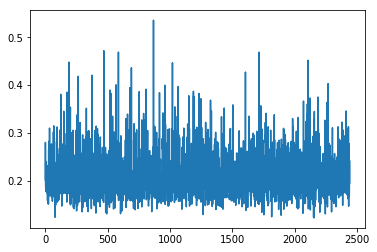

In [61]:
plt.plot(list(map(lambda t:t[0], tr_metrics)))

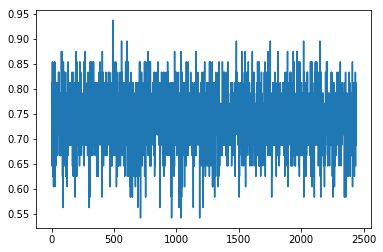

In [62]:
plt.plot(list(map(lambda t:t[1], tr_metrics)))

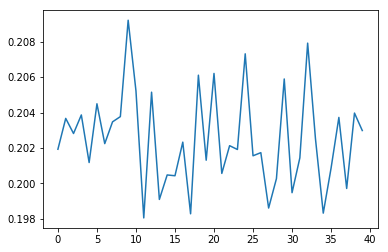

In [63]:
plt.plot(list(map(lambda t:t[0], tr_va_metrics)))
plt.plot(list(map(lambda t:t[0], te_va_metrics)))

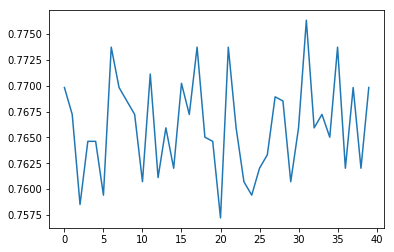

In [64]:
plt.plot(list(map(lambda t:t[1], tr_va_metrics)))
plt.plot(list(map(lambda t:t[1], te_va_metrics)))

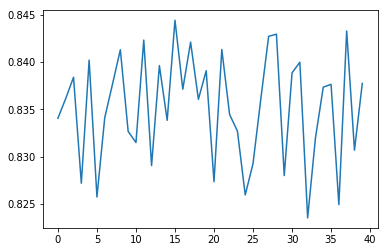

In [65]:
plt.plot(list(map(lambda t:t[2], tr_va_metrics)))
plt.plot(list(map(lambda t:t[2], te_va_metrics)))

In [66]:
torch.save({'model': model.state_dict(),
           'optimizer': optimizer.state_dict()}, '/kaggle/working/checkpoint.tar')